In [1]:
import zipfile

zip_path = "/content/InstrumentalSounds_FULL.zip"  # Replace with the actual path to your zip file
extract_path = "/content"  # Replace with the path where you want to extract the contents

# Extract the contents of the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# **TASK 4** : 80% accuracy

In [75]:
import librosa
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def classify_excitation(audio_file_path, energy_threshold=0.1, attack_time_threshold=0.44, duration_threshold=6):
    # Load audio file using librosa
    y, sr = librosa.load(audio_file_path)

    # Calculate energy
    energy = sum(y**2) / len(y)
    #print("energy:", energy)

    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env)
    attack_time = librosa.frames_to_time(onset_frames[0], sr=sr)
    #print(attack_time)
    # Calculate effective duration
    duration = librosa.get_duration(y=y, sr=sr)
    #print("duration",duration)
    # Define rules for classification
    if energy<energy_threshold and attack_time < attack_time_threshold and duration < duration_threshold:
        return "percussive"
    else:
        return "non-percussive"

# Function to evaluate the binary classification
def evaluate_binary_classification(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, pos_label="percussive")
    recall = recall_score(true_labels, predicted_labels, pos_label="percussive")
    f1 = f1_score(true_labels, predicted_labels, pos_label="percussive")
    conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=["percussive", "non-percussive"])

    return accuracy, precision, recall, f1, conf_matrix

# Folder path containing audio files
folder_path = "/content/new/InstrumentalSounds_FULL"

# Get the list of files in the folder
file_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# True labels (assuming percussive and non-percussive are known)
true_labels = ["percussive" if "pizz" in filename else "non-percussive" for filename in file_list]

# Predicted labels based on energy and effective duration
predicted_labels = [classify_excitation(os.path.join(folder_path, filename)) for filename in file_list]

# Evaluate the classification
accuracy, precision, recall, f1, conf_matrix = evaluate_binary_classification(true_labels, predicted_labels)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8
Precision: 0.6666666666666666
Recall: 0.7272727272727273
F1-Score: 0.6956521739130435
Confusion Matrix:
[[16  6]
 [ 8 40]]


# **TASK 5**: 57% accuracy

Accuracy: 0.5714285714285714
Precision: 0.5714285714285714
Recall: 0.625
F1-Score: 0.5970149253731343
Confusion Matrix:


<ipython-input-74-65965ed38eb8>:95: RuntimeWarning: invalid value encountered in divide
  conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)


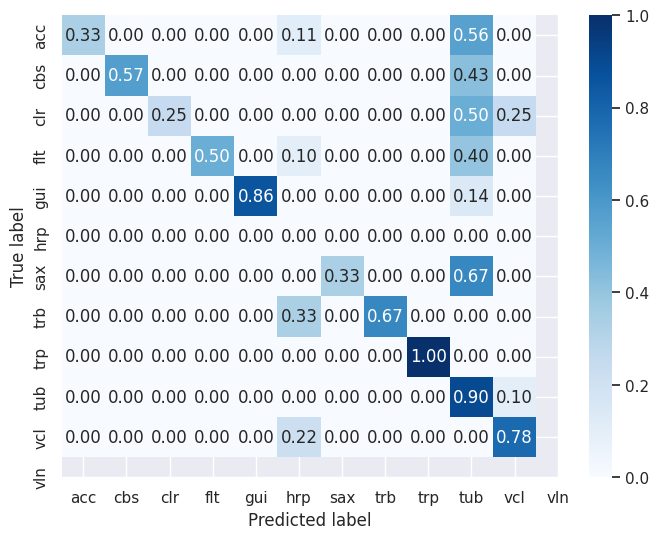

In [74]:
import seaborn as sns
import librosa
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Function to extract sound descriptors
def extract_sound_descriptors(audio_file_path):
    # Load audio file using librosa
    y, sr = librosa.load(audio_file_path)

    # Calculate spectral centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]

    # Calculate mean and standard deviation of descriptors
    mean_spectral_centroid = np.mean(spectral_centroid)
    #print("msc:", mean_spectral_centroid)
    std_spectral_centroid = np.std(spectral_centroid)
    #print("ssc:",std_spectral_centroid)

    onset_env = librosa.onset.onset_strength(y=y, sr=sr)
    onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env)
    attack_time = librosa.frames_to_time(onset_frames[0], sr=sr)
    #print(attack_time)
    # Calculate effective duration
    duration = librosa.get_duration(y=y, sr=sr)
    #print("duration",duration)

    # Concatenate features and instrument name
    features = [mean_spectral_centroid, std_spectral_centroid, attack_time, duration, instrument_name]
    #print(features)
    return features

# Function to classify instruments based on descriptors
def classify_instrument(features):
    # Define rules for classification
    thresholds = {
        "acc": {"lower" : [1199, 212, 0.069, 5.43], "upper" : [1832, 578, 0.14, 7.52]},
        "cbs": {"lower" : [588, 168, 0.09, 1.47],   "upper" : [1205, 397, 0.19, 13.14]},
        "clr": {"lower" : [1043, 281, 0.069, 7.21], "upper" : [2317, 370, 0.52, 8.35]},
        "flt": {"lower" : [1265, 217, 0.069, 7.97], "upper" : [1997, 412, 0.38, 8.39]},
        "gui": {"lower" : [454, 143, 0.18, 3.56],   "upper" : [1318, 771, 0.42, 6.43]},
        "hrp": {"lower" : [486, 190, 0.069, 3.54],  "upper" : [1557, 1286, 0.07, 17.71]},
        "sax": {"lower" : [820, 109, 0.069, 9.69],  "upper" : [1649, 502, 0.35, 10.6]},
        "trb": {"lower" : [667, 132, 0.3, 6.62],    "upper" : [811, 183, 0.35, 7.14]},
        "trp": {"lower" : [1312, 250, 0.11, 7.25],  "upper" : [1690, 376, 0.26, 7.82]},
        "tub": {"lower" : [454, 238, 0.069, 3.81],  "upper" : [536, 304, 0.1, 4.3]},
        "vcl": {"lower" : [726, 101, 0.069, 1.33],  "upper" : [2240, 439, 0.26, 12.35]},
        "vln": {"lower" : [1243, 190, 0.069, 7.57], "upper" : [3133, 892, 0.38, 9.63]},
    }

    predicted_instrument = "noInstrumentFound"

    for instrument, threshold_values in thresholds.items():
        lower_threshold = threshold_values["lower"]
        upper_threshold = threshold_values["upper"]
        if all(l <= f <= u for f, l, u in zip(features, lower_threshold, upper_threshold)):
            predicted_instrument = instrument

    return predicted_instrument

# Folder path containing audio files for different instruments
folder_path = "/content/new/InstrumentalSounds_FULL"


# Extract features and classify instruments
true_labels = []
predicted_labels = []

for filename in file_list:
    instrument_name = filename.split('_')[0]  # Assuming the instrument name is the prefix before '_'
    true_labels.append(instrument_name)
    file_path = os.path.join(folder_path, filename)
    sound_features = extract_sound_descriptors(file_path)
    predicted_instrument = classify_instrument(sound_features)
    predicted_labels.append(predicted_instrument)

# Evaluate the classification
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='micro', labels=np.unique(predicted_labels))
recall = recall_score(true_labels, predicted_labels, average='micro', labels=np.unique(predicted_labels))
f1 = f1_score(true_labels, predicted_labels, average='micro', labels=np.unique(predicted_labels))
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=np.unique(predicted_labels))

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Confusion Matrix:")
# Class labeling
class_labels = ["acc", "cbs", "clr", "flt", "gui", "hrp", "sax", "trb", "trp", "tub", "vcl", "vln"]

# Normalization of confusion matrix
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1, keepdims=True)
conf_matrix = np.nan_to_num(conf_matrix)

# Heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1)  # Font size

heatmap = sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt=".2f", xticklabels=class_labels, yticklabels=class_labels)
heatmap.set_xlabel('Predicted label')
heatmap.set_ylabel('True label')
plt.show()
#print(conf_matrix)
